Ща будем смачно файнтюнить трансформер на классификацию научных текстов прям как хотели в домашке DLS

Для начала создадим датасет при помощи SentencePiece и

In [2]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import nltk
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer


import torch
from torch.utils.data import DataLoader
from torch import nn

from dataset import MathClassificationDataset, SentencePieceTokenizer, NltkTokenizer
from model import TransformerClassificationModel, LogisticRegression

In [3]:
DATASET_PATH = "dataset.csv"

<Axes: >

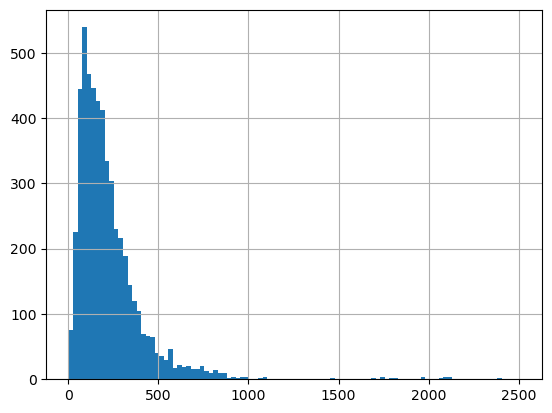

In [4]:
data = pd.read_csv(DATASET_PATH)
lengths = data["problem_text"].map(len)
lengths.hist(bins=100)

In [5]:
MAX_LENGTH = 512

sentence_piece_tokenizer = SentencePieceTokenizer(vocab_size=2000, tokenizer_model_name="bpe_tokenizer_2000", dataset_path=DATASET_PATH)

# nltk.download('wordnet')
# nltk.download("stopwords")
nltk_tokenizer = NltkTokenizer(dataset_path=DATASET_PATH)

train_set = MathClassificationDataset(
    dataset_path=DATASET_PATH,
    tokenizer=nltk_tokenizer,
    max_length=MAX_LENGTH,
    train=True
)
val_set = MathClassificationDataset(
    dataset_path=DATASET_PATH,
    tokenizer=nltk_tokenizer,
    max_length=MAX_LENGTH,
    train=False
)

In [39]:
def prepare_text_for_tf_idf(ids, dataset: MathClassificationDataset):
    filtered_ids = [ind for ind in ids if ind != dataset.pad_id and ind != dataset.eos_id and ind != dataset.bos_id]
    return dataset.tokenizer.ids2text(filtered_ids)

In [40]:
def prepare_batch_for_tf_idf(batch, dataset):
    prepared_dataset = []
    for ids in batch:
        prepared_dataset.append(prepare_text_for_tf_idf(ids, dataset))
    return prepared_dataset

In [41]:
processed_train = prepare_batch_for_tf_idf(train_set.indices["problem_text"], train_set)
processed_val = prepare_batch_for_tf_idf(val_set.indices["problem_text"], train_set)

Посмотрим на число токенов в полученных текстах

In [42]:
found = set()
for text in processed_train + processed_val:
    for word in text.split():
        found.add(word)
len(found)

3302

В словаре как раз на три служебных больше

In [43]:
nltk_tokenizer.vocab_size()

3305

Но 23 токена куда-то деваются при tf-idf векторизации... Оказывается, дело в регулярном выражении, которое не допускало токены из одного символа

In [44]:
tf_idf = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b").fit(processed_train + processed_val)
tf_idf.transform(processed_train + processed_val).toarray().shape

(5273, 3302)

In [196]:
BATCH_SIZE = 512  # Небольшой батч для большей регуляризации (чтобы с меньшим риском попасть в узкий минимум)
NUM_EPOCHS = 35

baseline = LogisticRegression(text_embedding_dim=train_set.vocab_size - 3, dataset=train_set)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
# optimizer = torch.optim.SGD(baseline.parameters(), momentum=0.9, lr=0.001, weight_decay=0.7)
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.00005, weight_decay=0.4)  # адаптивный шаг хорош для разреженных признаков
criterion = nn.CrossEntropyLoss()

In [197]:
from train import plot_losses


def training_epoch(model, loader, dataset, optimizer, criterion, tqdm_desc):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch, labels in tqdm(loader, tqdm_desc):
        processed_batch_list = prepare_batch_for_tf_idf(batch.cpu().tolist(), dataset)
        #print(tf_idf.transform(processed_batch_list).toarray())
        batch = torch.tensor(tf_idf.transform(processed_batch_list).toarray(), dtype=torch.float)

        optimizer.zero_grad()
        logits = model(batch)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_accuracy += torch.sum(torch.argmax(logits, dim=-1) == labels) / len(batch)

    return epoch_loss / len(loader), epoch_accuracy / len(loader)


@torch.no_grad()
def validating_epoch(model, loader, dataset, optimizer, criterion, tqdm_desc):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch, labels in tqdm(loader, tqdm_desc):
        processed_batch_list = prepare_batch_for_tf_idf(batch.cpu().tolist(), dataset)
        batch = torch.tensor(tf_idf.transform(processed_batch_list).toarray(), dtype=torch.float)

        optimizer.zero_grad()
        logits = model(batch)
        loss = criterion(logits, labels)

        epoch_loss += loss.item()
        epoch_accuracy += torch.sum(torch.argmax(logits, dim=-1) == labels) / len(batch)

    return epoch_loss / len(loader), epoch_accuracy / len(loader)


def train(model, train_loader, train_set, val_loader, val_set, optimizer, criterion, num_epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, train_loader, train_set, optimizer, criterion,
            tqdm_desc=f"training on epoch {epoch} / {num_epochs}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = validating_epoch(
            model, val_loader, val_set, optimizer, criterion,
            tqdm_desc=f"validating on epoch {epoch} / {num_epochs}"
        )
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        plot_losses(train_losses, train_accuracies, val_losses, val_accuracies)

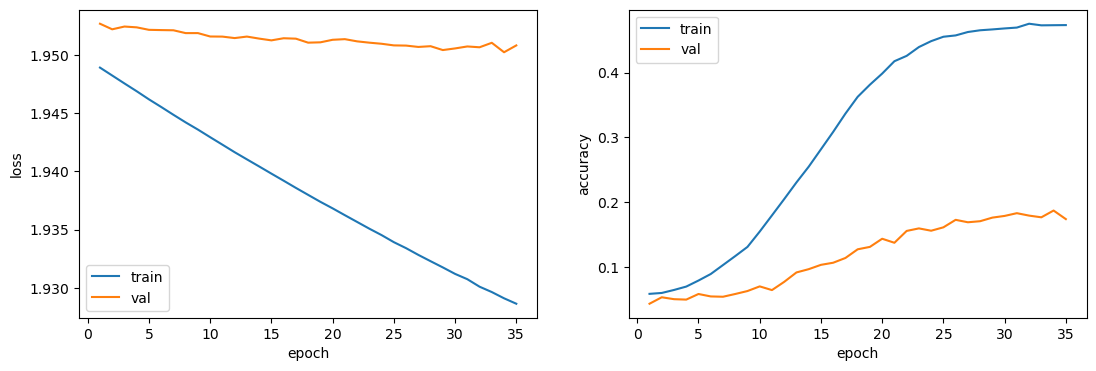

In [198]:
train(baseline, train_loader, train_set, val_loader, val_set, optimizer, criterion, num_epochs=NUM_EPOCHS)

Чтобы регуляризовать модель, я использовал не слишком большой размер батча (64 - 128 - 256 - 512), тк похоже, что мы попали в какой-то узкий минимум. Попробовать можно также

In [23]:
k = torch.tensor([
    [1, 1],
    [2, 2]
], dtype=torch.int64)

x = torch.tensor([
    [
        [1, 3],
        [1, 2],
        [0, 0]
    ],
    [
        [1, 3],
        [1, 2],
        [0, 0]
    ]
], dtype=torch.int64)

torch.matmul(x, k)

tensor([[[7, 7],
         [5, 5],
         [0, 0]],

        [[7, 7],
         [5, 5],
         [0, 0]]])